In [1]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

In [2]:
evspsblpot_method = 'allen98'

### Step 1: Read data

In [3]:
if evspsblpot_method == 'hargreaves85':
    infile = '/g/data/xv83/dbi599/treasury/spei-hargreaves85_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_185001-210012.nc'
elif evspsblpot_method == 'allen98':
    infile = '/g/data/xv83/dbi599/treasury/spei-allen98_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_195001-210012.nc'

In [4]:
ds = xr.open_dataset(infile)

In [5]:
ds

<xarray.Dataset> Size: 404MB
Dimensions:  (lat: 145, lon: 192, time: 1812)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 14kB 1950-01-01 1950-02-01 ... 2100-12-01
Data variables:
    SPEI     (time, lat, lon) float64 404MB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T17:41:46Z
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/585d8ccf-c461-43d5-83e1-4843ec6ba2a7
    license:                CMIP6 model data produced by CSIRO is licensed un...

### Step 2: Read shapefiles

In [6]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [7]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [8]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [9]:
states_gp = states_gp[:-2]

In [10]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [11]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [12]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [13]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [14]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [15]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [16]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [17]:
type(states_regions)

regionmask.core.regions.Regions

In [18]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


### Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [19]:
frac = states_regions.mask_3D_frac_approx(ds)

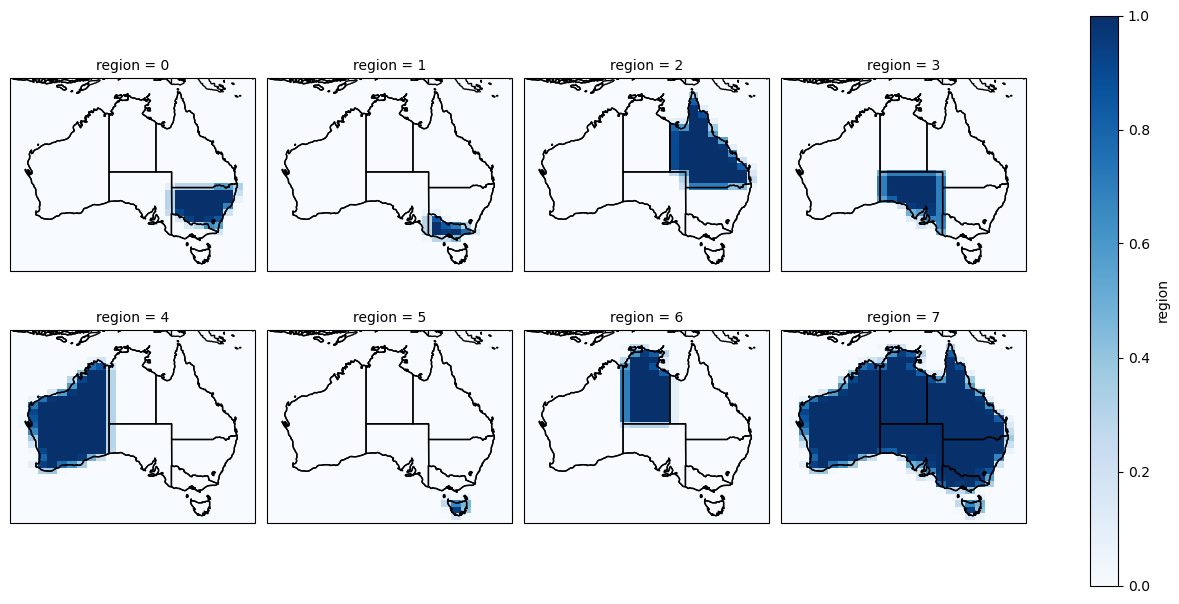

In [20]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

### Final step: Calculate a (weighted) regional mean

In [21]:
weights = np.cos(np.deg2rad(ds['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

In [22]:
spatial_means = ds['SPEI'].weighted(frac * weights).mean(dim=("lat", "lon"))

In [23]:
print(spatial_means)

<xarray.DataArray 'SPEI' (time: 1812, region: 8)> Size: 116kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-3.41779857, -2.2251693 , -3.4966299 , ..., -4.60075014,
        -4.32851391, -4.67409768],
       [-3.19044454, -3.16224009, -3.04097914, ..., -4.54323988,
        -4.63320669, -4.82518457],
       [-2.99744976, -3.91563743, -2.9855164 , ..., -3.76993423,
        -5.62754867, -5.20428515]], shape=(1812, 8))
Coordinates:
  * time     (time) datetime64[ns] 14kB 1950-01-01 1950-02-01 ... 2100-12-01
  * region   (region) int64 64B 0 1 2 3 4 5 6 7
    abbrevs  (region) <U3 96B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT' 'AUS'
    names    (region) <U18 576B 'New South Wales' 'Victoria' ... 'Australia'


In [24]:
df = spatial_means.to_pandas()
df.columns = spatial_means['abbrevs']
df = df.round(decimals=2)

In [25]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2100-08-01,-4.28,-3.15,-3.80,-6.14,-6.25,-4.58,-4.48,-5.06
2100-09-01,-4.21,-2.71,-3.87,-4.87,-6.30,-4.38,-4.46,-4.91
2100-10-01,-3.42,-2.23,-3.50,-4.83,-6.22,-4.60,-4.33,-4.67


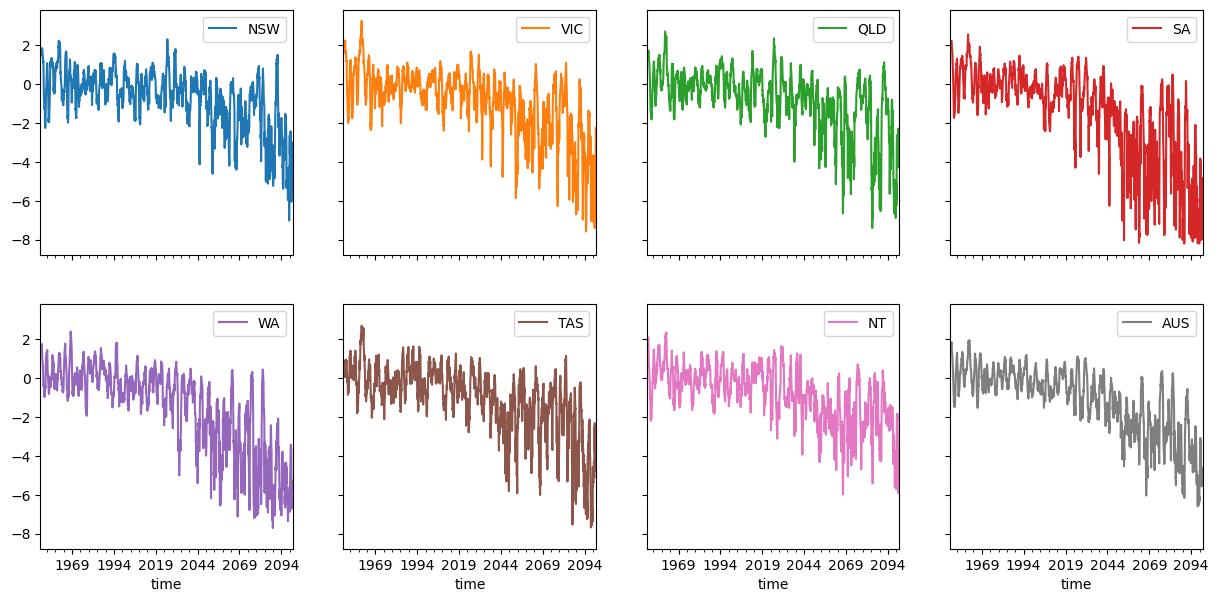

In [26]:
df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[2,4],
    sharey=True,
)
plt.show()

In [27]:
df.index = df.index.strftime('%Y-%m')

In [28]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1950-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2100-08,-4.28,-3.15,-3.80,-6.14,-6.25,-4.58,-4.48,-5.06
2100-09,-4.21,-2.71,-3.87,-4.87,-6.30,-4.38,-4.46,-4.91
2100-10,-3.42,-2.23,-3.50,-4.83,-6.22,-4.60,-4.33,-4.67


In [29]:
if evspsblpot_method == 'hargreaves85':
    outfile = '/g/data/xv83/dbi599/treasury/spei-hargreaves85_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states_1850-2100.csv'
elif evspsblpot_method == 'allen98':
    outfile = '/g/data/xv83/dbi599/treasury/spei-allen98_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_1950-2100.csv'

In [30]:
outfile

'/g/data/xv83/dbi599/treasury/spei-allen98_mon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_1950-2100.csv'

In [31]:
df.to_csv(outfile)